In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pyxdf

In [2]:
WPI_xdf_path = "HCILab-Group9.xdf"
CSL_xdf_path = "CSL_Laptop_1312.xdf"

### View XDF Streams

In [3]:
def view_xdf_streams(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    print(header)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        print(f'Stream {stream_name}')

In [4]:
view_xdf_streams(WPI_xdf_path)

{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-12-13T09:43:02-0500']})}
Stream Unicorn_HCILab1
Stream OBS_HCILab1
Stream Unicorn_HCILab2
Stream OBS_HCILab2
Stream OBS_CSL_Laptop


In [5]:
view_xdf_streams(CSL_xdf_path)

{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-12-13T15:43:03+0100']})}
Stream Unicorn_CSL_Laptop
Stream OBS_CSL_Laptop
Stream OBS_HCILab1
Stream Unicorn_HCILab1


In [ ]:
def view_stream_keys(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    # Print all keys in the stream to inspect the structure
    print(f"Keys in a stream:")
    for key in data[0].keys():
        print(f"- {key}")

view_stream_keys(WPI_xdf_path)

From running the code above, we get that each stream contains:

- info
- footer
- time_series (contains UNIX time stampes for OBS streams)
- time_stamps (contain Lab Recorder time stamps)
- clock_times
- clock_values

Also, from examining the streams of both WPI HCI Lab and CSL xdf files, we get that:

The WPI HCI Lab Stream Names:

- Stream OBS_HCILab1
- Stream Unicorn_HCILab1 (shared)
- Stream OBS_HCILab2 (shared)
- Stream Unicorn_HCILab2
- Stream Unicorn_CSL_LabPC
- Stream OBS_CSL_Laptop

The CSL Lab Stream Names:

- Stream OBS_CSL_Laptop
- Stream Unicorn_CSL_Laptop
- Stream Unicorn_CSL_LabPC
- Stream OBS_CSL_LabPC
- Stream OBS_HCILab2 (shared)
- Stream Unicorn_HCILab1 (shared)

We see that both lab xdf files share OBS_HCILab2 and Unicorn_HCILab1! So, since the same OBS stream is in multiple files, below, I will find the index of the where the UNIX timestamp at the start of the later recording also occurs in the earlier ones. Once I get the LabRecorder timestamp at this index, I will cut all the EEG data with timestamps lower than this value to sync all streams.

Note: the shared streams and streams are only examples from Group 1.

In [6]:
def examine_timestamps_length(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        
        time_stamps = stream["time_stamps"]
        
        print(f'Stream {stream_name} has {len(time_stamps)} time stamps, starting with {time_stamps[0]}')
        
        time_series = stream["time_series"]
        if stream_name.startswith("OBS"):
            print(f"Stream {stream_name} with time series (UNIX) begins with {time_series[0][0]}")

# Examine the length of all time stamps in each stream for both XDF files
print("WPI HCI Lab Streams:")
examine_timestamps_length(WPI_xdf_path)

print("\nCSL Lab Streams:")
examine_timestamps_length(CSL_xdf_path)

WPI HCI Lab Streams:
Stream Unicorn_HCILab1 has 961607 time stamps, starting with 3385.087369837378
Stream OBS_HCILab1 has 115647 time stamps, starting with 3382.1029780572767
Stream OBS_HCILab1 with time series (UNIX) begins with 1734100982.883
Stream Unicorn_HCILab2 has 947133 time stamps, starting with 3363.470890261479
Stream OBS_HCILab2 has 110211 time stamps, starting with 3396.269159257672
Stream OBS_HCILab2 with time series (UNIX) begins with 1734101000.565
Stream OBS_CSL_Laptop has 115641 time stamps, starting with 3382.2766307657594
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1734100983.052

CSL Lab Streams:
Stream Unicorn_CSL_Laptop has 964412 time stamps, starting with 4497.369249842102
Stream OBS_CSL_Laptop has 115588 time stamps, starting with 4497.5399709306075
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1734100983.519
Stream OBS_HCILab1 has 115581 time stamps, starting with 4497.699666245019
Stream OBS_HCILab1 with time series (UNIX) begins w

### Investigate any weird stream

In [7]:
# only run for Group 9 -- (Unix time of OBS_HCILab2 seems to be the latest, but is it really)

# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

# Get the starting Unix time of OBS_CSL_Laptop
# potential_starting_unix_time = WPI_data_streams[2]["time_series"][0][0]
# print(f"Potential starting Unix time for OBS_HCILab2: {potential_starting_unix_time}")

# Get the first potential time stamp for OBS_HCILab2
potential_HCILab2_time_stamp_start = WPI_data_streams[2]["time_stamps"][0]

# Find the index of the time stamp of OBS_HCILab2 that is closest to the potential_HCILab2_time_stamp_start
index = np.searchsorted(WPI_data_streams[2]["time_stamps"], potential_HCILab2_time_stamp_start)

OBS_HCILab2_true_unix_start = WPI_data_streams[2]["time_series"][index][0]
print(f"True Unix start time for OBS_HCILab2: {OBS_HCILab2_true_unix_start}")

True Unix start time for OBS_HCILab2: 191345.328125


In [10]:
# only run for Group 3 and 8 -- weird streams for Group 3 and 8!! (Unix time of OBS_CSL_Laptop seems to be the latest, but it is actually OBS_HCILab2)

# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

# Get the starting Unix time of OBS_CSL_Laptop
potential_starting_unix_time = CSL_data_streams[2]["time_series"][0][0]
print(f"Potential starting Unix time for OBS_CSL_Laptop: {potential_starting_unix_time}")

# Get the first potential time stamp for OBS_HCILab2
potential_HCILab2_time_stamp_start = WPI_data_streams[3]["time_stamps"][0]

# Find the index of the time stamp of OBS_HCILab2 that is closest to the potential_HCILab2_time_stamp_start
index = np.searchsorted(WPI_data_streams[2]["time_stamps"], potential_HCILab2_time_stamp_start)

OBS_HCILab2_true_unix_start = WPI_data_streams[2]["time_series"][index][0]
print(f"True Unix start time for OBS_HCILab2: {OBS_HCILab2_true_unix_start}")

Stream 2: Calculated effective sampling rate 26.1407 Hz is different from specified rate 30.0000 Hz.
Stream 2: Calculated effective sampling rate -1.0738 Hz is different from specified rate 30.0000 Hz.
Stream 3: Calculated effective sampling rate -0.8356 Hz is different from specified rate 250.0000 Hz.


Potential starting Unix time for OBS_CSL_Laptop: 1731941507.595
True Unix start time for OBS_HCILab2: 1731941531.402


### Sync Streams!!

In [15]:
def sync_streams(data_streams_1, data_streams_2):
    
    """
    Sync the data by trimming time_stamp and time_series streams so that all EEG and Unicorn Streams begin at the same time
    
    Parameters:
    - data_streams_1: Stream data from WPI HCI Lab xdf file
    - data_streams_2: Stream data from CSL Lab xdf file
    """
    
    # Holds the 8 streams (4 OBS and 4 Unicorn)
    streams = {}
    
    # Create mappings of the 8 stream names to streams
    for stream in data_streams_1:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_HCILab1", "Unicorn_HCILab1", "OBS_HCILab2", "Unicorn_HCILab2"]:
            streams[stream_name] = stream
            
    for stream in data_streams_2:
        stream_name = stream["info"]["name"][0]
        
        # if stream_name in ["OBS_CSL_Laptop", "Unicorn_CSL_Laptop", "OBS_CSL_LabPC", "Unicorn_CSL_LabPC"]:
        if stream_name in ["OBS_CSL_Laptop", "Unicorn_CSL_Laptop", "Unicorn_CSL_LabPC"]:  # only for Group 2 and 9 - missing OBS_CSL_LabPC
            streams[stream_name] = stream
    
    # Find the stream with the latest starting Unix timestamp
    latest_unix_timestamp = 0
    latest_OBS_stream = None
    
    for stream_name, stream in streams.items():
        if stream_name.startswith("OBS"):  # OBS streams have the Unix timestamps
            unix_timestamp = stream["time_series"][0][0]
            
            if unix_timestamp > latest_unix_timestamp:
                latest_unix_timestamp = unix_timestamp
                latest_OBS_stream = stream
    
    latest_OBS_stream = streams["OBS_HCILab2"]  # only for Group 3, 6, and 8
    latest_unix_timestamp = latest_OBS_stream["time_series"][0][0]  # only for Group 3, 6, and 8
    
    # Consider the case where the corresponding EEG stream's LabRecorder timestamp is later than the OBS stream's LabRecorder timestamp
    
    # Find the corresponding EEG stream
    corresponding_EEG_stream_name = "Unicorn" + latest_OBS_stream["info"]["name"][0][3:]
    corresponding_EEG_stream = streams[corresponding_EEG_stream_name]
    
    if corresponding_EEG_stream["time_stamps"][0] > latest_OBS_stream["time_stamps"][0]:
        # The EEG stream's LabRecorder timestamp is later than the OBS stream's LabRecorder timestamp
        print("cutting stream based on EEG!")
        
        # Find the index in the OBS stream where the EEG stream's start timestamp occurs
        index_in_OBS = np.searchsorted(latest_OBS_stream["time_stamps"], corresponding_EEG_stream["time_stamps"][0])
        
        # Update the latest Unix timestamp
        latest_unix_timestamp = latest_OBS_stream["time_series"][index_in_OBS][0]
    
    # Trim all the other streams based on the latest Unix timestamp
    for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop")]:
        OBS_stream = streams[OBS_stream_name]
        EEG_stream = streams[EEG_stream_name]
        
        # First, find the LabRecorder timestamp in the OBS stream that corresponds to the latest Unix timestamp
        OBS_unix_times = [ts[0] for ts in OBS_stream["time_series"]]
        index_in_OBS = np.searchsorted(OBS_unix_times, latest_unix_timestamp)
        
        if index_in_OBS < len(OBS_stream["time_stamps"]):
            labrecorder_timestamp = OBS_stream["time_stamps"][index_in_OBS]
        else:
            labrecorder_timestamp = OBS_stream["time_stamps"][-1]
        
        # Find the index in the EEG stream where this LabRecorder timestamp occurs
        index_in_EEG = np.searchsorted(EEG_stream["time_stamps"], labrecorder_timestamp)
        
        # Trim all the data in the OBS and EEG streams based on this index
        OBS_stream["time_stamps"] = OBS_stream["time_stamps"][index_in_OBS:]
        OBS_stream["time_series"] = OBS_stream["time_series"][index_in_OBS:]
        EEG_stream["time_stamps"] = EEG_stream["time_stamps"][index_in_EEG:]
        EEG_stream["time_series"] = EEG_stream["time_series"][index_in_EEG:]
    
    return streams


In [16]:
# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

In [10]:
# Before syncing the streams, let's examine the time_stamps and time_series in both files
def print_time_stamps_and_series(data_streams):
    for stream in data_streams:
        stream_name = stream["info"]["name"][0]
        print(f'\nStream {stream_name} has {len(stream["time_stamps"])} time stamps and {len(stream["time_series"])} time series')
        
        if len(stream["time_stamps"]) > 0:
            print(f'Starting time stamps: {stream["time_stamps"][0]} ...')
        
        if stream_name.startswith("OBS") and len(stream["time_series"]) > 0:
            print(f'Starting time series (UNIX): {stream["time_series"][0][0]} ...')
        
print("WPI HCI Lab Streams before syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams before syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams before syncing:

Stream Unicorn_HCILab1 has 961607 time stamps and 961607 time series
Starting time stamps: 3385.087369837378 ...

Stream OBS_HCILab1 has 115647 time stamps and 115647 time series
Starting time stamps: 3382.1029780572767 ...
Starting time series (UNIX): 1734100982.883 ...

Stream Unicorn_HCILab2 has 947133 time stamps and 947133 time series
Starting time stamps: 3363.470890261479 ...

Stream OBS_HCILab2 has 110211 time stamps and 110211 time series
Starting time stamps: 3396.269159257672 ...
Starting time series (UNIX): 1734101000.565 ...

Stream OBS_CSL_Laptop has 115641 time stamps and 115641 time series
Starting time stamps: 3382.2766307657594 ...
Starting time series (UNIX): 1734100983.052 ...

CSL Lab Streams before syncing:

Stream Unicorn_CSL_Laptop has 964412 time stamps and 964412 time series
Starting time stamps: 4497.369249842102 ...

Stream OBS_CSL_Laptop has 115588 time stamps and 115588 time series
Starting time stamps: 4497.53997093060

In [17]:
# Sync the streams based on the shared stream's timestamp
streams = sync_streams(WPI_data_streams, CSL_data_streams)

In [18]:
print("WPI HCI Lab Streams AFTER syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams AFTER syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams AFTER syncing:

Stream Unicorn_HCILab1 has 957935 time stamps and 957935 time series
Starting time stamps: 3399.806781565392 ...

Stream OBS_HCILab1 has 115116 time stamps and 115116 time series
Starting time stamps: 3399.803252226991 ...
Starting time series (UNIX): 1734101000.583 ...

Stream Unicorn_HCILab2 has 939117 time stamps and 939117 time series
Starting time stamps: 3396.2729756951203 ...

Stream OBS_HCILab2 has 110211 time stamps and 110211 time series
Starting time stamps: 3396.269159257672 ...
Starting time series (UNIX): 1734101000.565 ...

Stream OBS_CSL_Laptop has 115641 time stamps and 115641 time series
Starting time stamps: 3382.2766307657594 ...
Starting time series (UNIX): 1734100983.052 ...

CSL Lab Streams AFTER syncing:

Stream Unicorn_CSL_Laptop has 960097 time stamps and 960097 time series
Starting time stamps: 4514.608609277795 ...

Stream OBS_CSL_Laptop has 115076 time stamps and 115076 time series
Starting time stamps: 4514.606637412529 

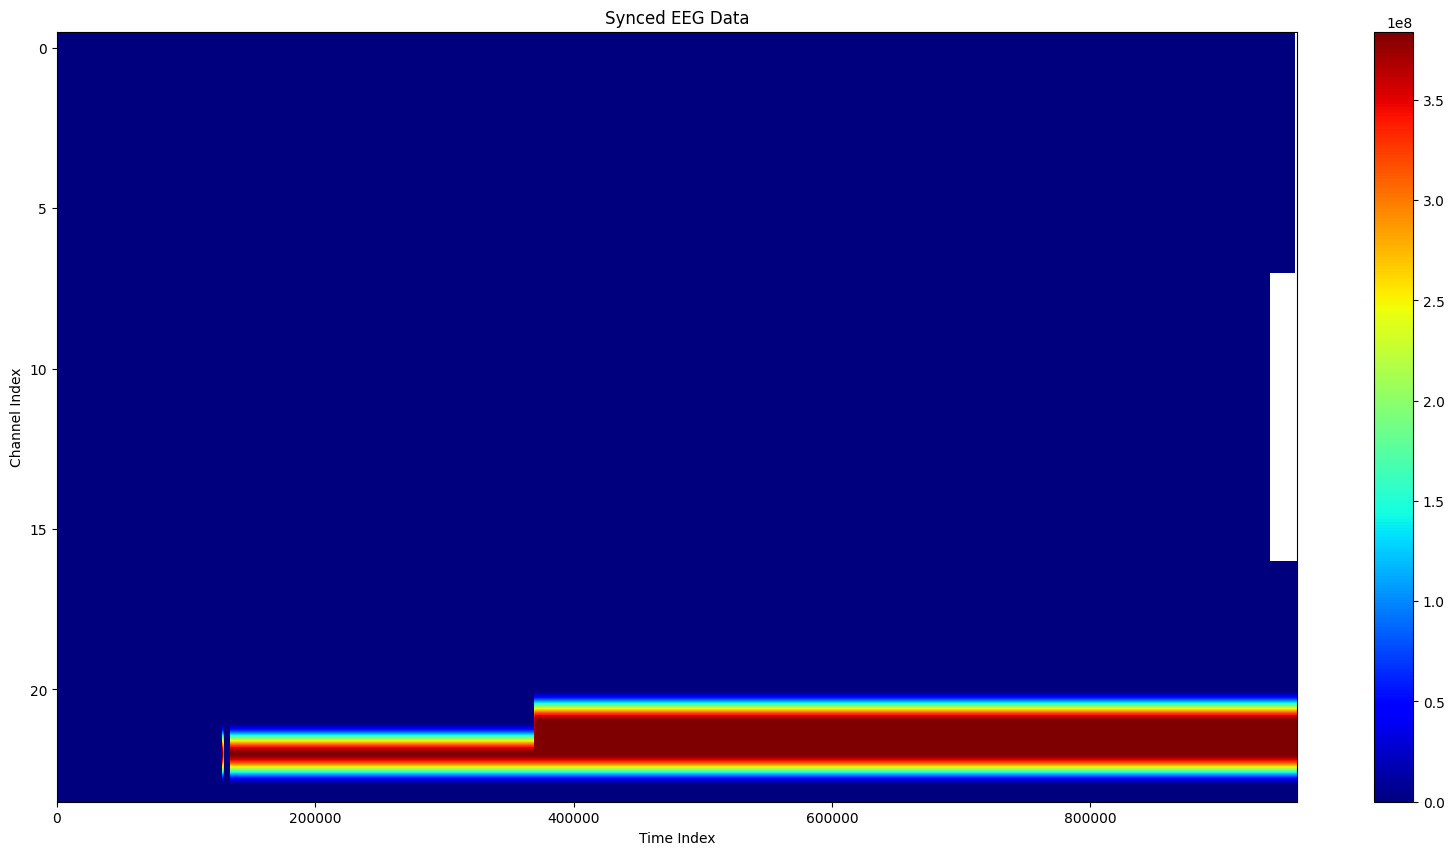

In [19]:
import scipy.io

# find the max length of time_series in all EEG streams to establish dimensions for synced EEG streams
max_length = 0

for stream_name in ["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop"]:
    max_length = max(max_length, len(streams[stream_name]["time_series"]))

# Create an np array to hold the synced EEG data with dimensions (max_length, 3 * 8)
synced_EEG_data = np.full((max_length, 3 * 8), np.nan)

# Fill in the synced EEG data
for j, stream_name in enumerate(["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop"]):
    EEG_stream = streams[stream_name]
    
    for time_index, eeg_data in enumerate(EEG_stream["time_series"]):
        synced_EEG_data[time_index, j * 8:(j + 1) * 8] = eeg_data[0:8]

# Visualize the synced EEG data
plt.figure(figsize=(20, 10))
plt.imshow(synced_EEG_data.T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title("Synced EEG Data")
plt.xlabel("Time Index")
plt.ylabel("Channel Index")
plt.show()

# Download the EEG data as an .mat file
scipy.io.savemat('synced_EEG_data_9.mat', {'synced_EEG_data_9': synced_EEG_data})